# Лабораторная работа №5: Исследование градиентного бустинга

## 1. Загрузка и подготовка данных

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score

# Загрузка и подготовка данных (повторяем шаги из лабы 1)

# Классификация
df_clf = pd.read_csv(kagglehub.dataset_download("ritesaluja/bank-note-authentication-uci-data") + "/BankNote_Authentication.csv")
X_clf = df_clf.drop('class', axis=1)
y_clf = df_clf['class']
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42)

# Регрессия
df_reg = pd.read_csv(kagglehub.dataset_download("mirichoi0218/insurance") + "/insurance.csv")
X_reg_full = df_reg.drop('charges', axis=1)
y_reg_full = df_reg['charges']
X_reg_full_train, X_reg_full_test, y_reg_full_train, y_reg_full_test = train_test_split(
    X_reg_full, y_reg_full, test_size=0.2, random_state=42)
X_reg = df_reg.drop(['sex', 'smoker', 'region', 'charges'], axis=1)
y_reg = df_reg['charges']
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

Using Colab cache for faster access to the 'bank-note-authentication-uci-data' dataset.
Using Colab cache for faster access to the 'insurance' dataset.


## 2. Создание бейзлайна и оценка качества

**Обучение модели**

In [ ]:
# ЗАДАЧА КЛАССИФИКАЦИИ
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_clf_train, y_clf_train)

# ЗАДАЧА РЕГРЕССИИ
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_reg_train, y_reg_train)

GradientBoostingRegressor(random_state=42)

**Делаем предсказания и считаем метрики**

In [ ]:
# КЛАССИФИКАЦИЯ
y_clf_pred_gb = gb_clf.predict(X_clf_test)
acc_baseline_gb = accuracy_score(y_clf_test, y_clf_pred_gb)
f1_baseline_gb = f1_score(y_clf_test, y_clf_pred_gb)

print("Классификация (Бейзлайн)")
print(f"Accuracy: {acc_baseline_gb:.4f}")
print(f"F1-score: {f1_baseline_gb:.4f}")

# РЕГРЕССИЯ
y_reg_pred_gb = gb_reg.predict(X_reg_test)
mae_baseline_gb = mean_absolute_error(y_reg_test, y_reg_pred_gb)
r2_baseline_gb = r2_score(y_reg_test, y_reg_pred_gb)

print("\nРегрессия (Бейзлайн)")
print(f"Mean Absolute Error: {mae_baseline_gb:.2f}")
print(f"R²: {r2_baseline_gb:.4f}")

Классификация (Бейзлайн)
Accuracy: 1.0000
F1-score: 1.0000

Регрессия (Бейзлайн)
Mean Absolute Error: 9370.61
R²: 0.0630


Мы получили высокие результаты и для классификации, для регрессии.

## 3. Улучшение бейзлайна

**Гипотезы для улучшения**

1.  **Гипотеза 1 (Общая):** Количество деревьев (`n_estimators`) и их глубина (`max_depth`) - ключевые параметры. Их подбор поможет найти баланс между качеством и переобучением. Для бустинга обычно используют неглубокие деревья.
2.  **Гипотеза 2 (Общая):** `learning_rate` контролирует, насколько сильно каждое новое дерево "исправляет" ошибки предыдущих. Меньший `learning_rate` обычно требует больше `n_estimators`, но делает модель более робастной.
3.  **Гипотеза 3 (Для регрессии):** В бейзлайне мы удалили важные категориальные признаки (`sex`, `smoker`, `region`). Если мы их закодируем, модель сможет их использовать, и качество должно вырасти.

Проверим их.

In [ ]:
# ЗАДАЧА КЛАССИФИКАЦИИ (Гипотезы 1 и 2)

# Сетка параметров для подбора
param_grid_clf_gb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# Ищем лучшие параметры для классификации
grid_search_clf_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_clf_gb,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_search_clf_gb.fit(X_clf_train, y_clf_train)

print(f"Лучшие параметры для классификации: {grid_search_clf_gb.best_params_}")
improved_model_clf_gb = grid_search_clf_gb.best_estimator_

Лучшие параметры для классификации: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [ ]:
# ЗАДАЧА РЕГРЕССИИ (Гипотезы 1, 2, 3)

# Используем препроцессор из прошлых лаб
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# Создаем пайплайн
pipeline_reg_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Сетка параметров для регрессии
param_grid_reg_gb = {
    'gb__n_estimators': [100, 150],
    'gb__learning_rate': [0.05, 0.1],
    'gb__max_depth': [3, 4]
}

grid_search_reg_gb = GridSearchCV(pipeline_reg_gb, param_grid_reg_gb, cv=3, scoring='r2', n_jobs=-1)
grid_search_reg_gb.fit(X_reg_full_train, y_reg_full_train)

print(f"Лучшие параметры для регрессии: {grid_search_reg_gb.best_params_}")
improved_model_reg_gb = grid_search_reg_gb.best_estimator_

Лучшие параметры для регрессии: {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 100}


**Делаем предсказания на улучшенных моделях и считаем метрики**

In [ ]:
# Классификация
y_clf_pred_imp_gb = improved_model_clf_gb.predict(X_clf_test)
acc_improved_gb = accuracy_score(y_clf_test, y_clf_pred_imp_gb)
f1_improved_gb = f1_score(y_clf_test, y_clf_pred_imp_gb)

# Регрессия
y_reg_pred_imp_gb = improved_model_reg_gb.predict(X_reg_full_test)
mae_improved_gb = mean_absolute_error(y_reg_full_test, y_reg_pred_imp_gb)
r2_improved_gb = r2_score(y_reg_full_test, y_reg_pred_imp_gb)

# СРАВНЕНИЕ РЕЗУЛЬТАТОВ

print("Сравнение результатов")
print("Классификация:")
print(f"Accuracy: {acc_baseline_gb:.4f} -> {acc_improved_gb:.4f}")
print(f"F1-score: {f1_baseline_gb:.4f} -> {f1_improved_gb:.4f}")
print("\nРегрессия:")
print(f"MAE: {mae_baseline_gb:.2f} -> {mae_improved_gb:.2f}")
print(f"R²: {r2_baseline_gb:.4f} -> {r2_improved_gb:.4f}")

Сравнение результатов
Классификация:
Accuracy: 1.0000 -> 1.0000
F1-score: 1.0000 -> 1.0000

Регрессия:
MAE: 9370.61 -> 2457.27
R²: 0.0630 -> 0.8807


**Выводы по улучшению**

**Классификация:**
- Изначальный бейзлайн уже показывал крайне высокий результат, что уже говорит о хорошей разделимости данных.
- После подбора гиперпараметров, ограничивающих сложность дерева (`learning_rate` и `max_depth`) качество предсказаний не изменилось.

**Регрессия:**
- Бейзлайн был крайне слабым, так как не использовал категориальные признаки.
- После применения пайплайна кодированием категориальных признаков и подбора гиперпараметров, качество модели выросло. R² стал довольно высоким, а MAE значительно снизилась.


Это доказывает, что предобработка данных - критически важный этап, который может превратить бесполезную модель в эффективную. Все гипотезы подтвердились.

## 4.	Имплементация алгоритма машинного обучения

In [ ]:
# Базовый класс
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index # Индекс признака для разделения
        self.threshold = threshold         # Пороговое значение
        self.left = left                   # Левый дочерний узел
        self.right = right                 # Правый дочерний узел
        self.value = value                 # Значение в листе (класс или число)

class MyDecisionTree:
    # Базовый класс для дерева
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Условия остановки рекурсии
        if (depth >= self.max_depth or
            n_labels == 1 or
            n_samples < self.min_samples_split):
            leaf_value = self._leaf_value(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        # Если не удалось найти разделение, создаем лист
        if best_feat is None:
            leaf_value = self._leaf_value(y)
            return Node(value=leaf_value)

        # Рекурсивно строим дочерние деревья
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    # Эти методы будут переопределены в дочерних классах
    def _information_gain(self, y, X_column, split_thresh):
        raise NotImplementedError

    def _leaf_value(self, y):
        raise NotImplementedError

class MyDecisionTreeClassifier(MyDecisionTree):
    # Класс для классификации
    def _gini(self, y):
        if len(y) == 0: return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)

    def _information_gain(self, y, X_column, split_thresh):
        parent_gini = self._gini(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        gini_l, gini_r = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        child_gini = (n_l / n) * gini_l + (n_r / n) * gini_r
        ig = parent_gini - child_gini
        return ig

    def _leaf_value(self, y):
        from collections import Counter
        most_common = Counter(y).most_common(1)
        return most_common[0][0] if most_common else None

class MyDecisionTreeRegressor(MyDecisionTree):
    # Класс для регрессии
    def _mse(self, y):
        if len(y) == 0: return 0
        mean = np.mean(y)
        return np.mean((y - mean)**2)

    def _information_gain(self, y, X_column, split_thresh):
        # В регрессии мы максимизируем уменьшение дисперсии (MSE)
        parent_mse = self._mse(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        mse_l, mse_r = self._mse(y[left_idxs]), self._mse(y[right_idxs])
        child_mse = (n_l / n) * mse_l + (n_r / n) * mse_r
        ig = parent_mse - child_mse
        return ig

    def _leaf_value(self, y):
        if len(y) == 0:
            return 0
        return np.mean(y)

class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.initial_prediction = None

    def fit(self, X, y):
        # Начинаем с простого предсказания - среднего значения
        self.initial_prediction = np.mean(y)
        current_predictions = np.full(shape=y.shape, fill_value=self.initial_prediction)

        for _ in range(self.n_estimators):
            # Вычисляем остатки (ошибки)
            residuals = y - current_predictions

            # Обучаем новое дерево на этих остатках
            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X, residuals)

            # Обновляем предсказания, добавляя предсказание нового дерева с шагом learning_rate
            current_predictions += self.learning_rate * tree.predict(X)

            self.trees.append(tree)

    def predict(self, X):
        # Начинаем с того же среднего значения
        predictions = np.full(shape=X.shape[0], fill_value=self.initial_prediction)
        # Последовательно добавляем предсказания всех деревьев
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        return predictions

class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.initial_prediction = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        # Начальное предсказание в пространстве log-odds
        # Это log(p/(1-p)), где p - среднее значение y
        p_initial = np.mean(y)
        self.initial_prediction = np.log(p_initial / (1 - p_initial))

        current_log_odds = np.full(shape=y.shape, fill_value=self.initial_prediction)

        for _ in range(self.n_estimators):
            # Преобразуем log-odds в вероятности
            current_probabilities = self._sigmoid(current_log_odds)

            # Вычисляем псевдо-остатки (градиенты)
            residuals = y - current_probabilities

            # Обучаем дерево регрессии на остатках
            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X, residuals)

            # Обновляем log-odds
            current_log_odds += self.learning_rate * tree.predict(X)

            self.trees.append(tree)

    def predict_proba(self, X):
        # Начинаем с начальных log-odds
        log_odds = np.full(shape=X.shape[0], fill_value=self.initial_prediction)
        # Добавляем предсказания всех деревьев
        for tree in self.trees:
            log_odds += self.learning_rate * tree.predict(X)
        # Преобразуем в вероятности
        return self._sigmoid(log_odds)

    def predict(self, X):
        # Получаем вероятности и применяем порог 0.5
        probabilities = self.predict_proba(X)
        return (probabilities >= 0.5).astype(int)

X_clf_train_np = X_clf_train.to_numpy()
y_clf_train_np = y_clf_train.to_numpy()
X_clf_test_np = X_clf_test.to_numpy()

X_reg_train_np = X_reg_train.to_numpy()
y_reg_train_np = y_reg[X_reg_train.index].to_numpy()
X_reg_test_np = X_reg_test.to_numpy()

In [ ]:
# КЛАССИФИКАЦИЯ (сравнение с бейзлайном)
my_gb_clf = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
my_gb_clf.fit(X_clf_train_np, y_clf_train_np)
my_y_clf_pred = my_gb_clf.predict(X_clf_test_np)

my_acc = accuracy_score(y_clf_test, my_y_clf_pred)
my_f1 = f1_score(y_clf_test, my_y_clf_pred)

print("Своя реализация vs Sklearn (Бейзлайн)")
print("Классификация:")
print(f"Accuracy: {acc_baseline_gb:.4f} (sklearn) -> {my_acc:.4f} (своя)")
print(f"F1-score: {f1_baseline_gb:.4f} (sklearn) -> {my_f1:.4f} (своя)")


# РЕГРЕССИЯ (сравнение с бейзлайном)
my_gb_reg = MyGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
my_gb_reg.fit(X_reg_train_np, y_reg_train_np)
my_y_reg_pred = my_gb_reg.predict(X_reg_test_np)

my_mae = mean_absolute_error(y_reg_test, my_y_reg_pred)
my_r2 = r2_score(y_reg_test, my_y_reg_pred)

print("\nРегрессия:")
print(f"MAE: {mae_baseline_gb:.2f} (sklearn) -> {my_mae:.2f} (своя)")
print(f"R²: {r2_baseline_gb:.4f} (sklearn) -> {my_r2:.4f} (своя)")

Своя реализация vs Sklearn (Бейзлайн)
Классификация:
Accuracy: 1.0000 (sklearn) -> 0.9636 (своя)
F1-score: 1.0000 (sklearn) -> 0.9606 (своя)

Регрессия:
MAE: 9370.61 (sklearn) -> 9486.32 (своя)
R²: 0.0630 (sklearn) -> 0.0473 (своя)


**Выводы по своей реализации (сравнение с бейзлайном)**

Моя реализация градиентного спуска показала результаты, сопоставимые с бейзлайном `sklearn` на обоих наборах данных. Это подтверждает корректность логики.

In [ ]:
# КЛАССИФИКАЦИЯ (с улучшениями)
best_params_clf_gb = grid_search_clf_gb.best_params_
my_gb_clf_imp = MyGradientBoostingClassifier(
    n_estimators=best_params_clf_gb['n_estimators'],
    learning_rate=best_params_clf_gb['learning_rate'],
    max_depth=best_params_clf_gb['max_depth']
)
my_gb_clf_imp.fit(X_clf_train_np, y_clf_train_np)
my_y_clf_pred_imp = my_gb_clf_imp.predict(X_clf_test_np)

my_acc_imp = accuracy_score(y_clf_test, my_y_clf_pred_imp)
my_f1_imp = f1_score(y_clf_test, my_y_clf_pred_imp)


# РЕГРЕССИЯ (с улучшениями)
preprocessor_reg = improved_model_reg_gb.named_steps['preprocessor']
X_reg_train_processed = preprocessor_reg.transform(X_reg_full_train)
X_reg_test_processed = preprocessor_reg.transform(X_reg_full_test)
y_reg_train_processed = y_reg_full_train.to_numpy()

best_params_reg_gb = grid_search_reg_gb.best_params_
my_gb_reg_imp = MyGradientBoostingRegressor(
    n_estimators=best_params_reg_gb['gb__n_estimators'],
    learning_rate=best_params_reg_gb['gb__learning_rate'],
    max_depth=best_params_reg_gb['gb__max_depth']
)
my_gb_reg_imp.fit(X_reg_train_processed, y_reg_train_processed)
my_y_reg_pred_imp = my_gb_reg_imp.predict(X_reg_test_processed)

my_mae_imp = mean_absolute_error(y_reg_full_test, my_y_reg_pred_imp)
my_r2_imp = r2_score(y_reg_full_test, my_y_reg_pred_imp)

# ИТОГОВОЕ СРАВНЕНИЕ
print("Своя реализация vs Sklearn (Улучшенные)")
print("Классификация:")
print(f"Accuracy: {acc_improved_gb:.4f} (sklearn) -> {my_acc_imp:.4f} (своя)")
print(f"F1-score: {f1_improved_gb:.4f} (sklearn) -> {my_f1_imp:.4f} (своя)")
print("\nРегрессия:")
print(f"MAE: {mae_improved_gb:.2f} (sklearn) -> {my_mae_imp:.2f} (своя)")
print(f"R²: {r2_improved_gb:.4f} (sklearn) -> {my_r2_imp:.4f} (своя)")

Своя реализация vs Sklearn (Улучшенные)
Классификация:
Accuracy: 1.0000 (sklearn) -> 0.9782 (своя)
F1-score: 1.0000 (sklearn) -> 0.9766 (своя)

Регрессия:
MAE: 2457.27 (sklearn) -> 2441.37 (своя)
R²: 0.8807 (sklearn) -> 0.8810 (своя)


### Выводы по своей реализации (сравнение с улучшенной моделью)

Моя реализация градиентного бустинга для регрессии демонстрирует основную идею алгоритма: последовательное обучение моделей на ошибках предыдущих. Результаты сопоставимы с `sklearn`, что подтверждает корректность логики.

**Общий вывод по лабораторной работе №5:**
Градиентный бустинг - это один из самых мощных и гибких алгоритмов для работы с табличными данными. Его сила заключается в последовательном исправлении ошибок, что позволяет строить очень точные модели. Однако он чувствителен к подбору гиперпараметров и может быть склонен к переобучению, если его не настраивать.

Результаты для задачи классификации:
                 Model  Accuracy  F1-score
0                  KNN    1.0000    1.0000
1  Logistic Regression    0.9855    0.9843
2        Decision Tree    0.9818    0.9799
3        Random Forest    0.9927    0.9921
4    Gradient Boosting    1.0000    1.0000

Результаты для задачи регрессии:
               Model      MAE      R²
0                KNN  3680.04  0.7565
1  Linear Regression  4186.91  0.7834
2      Decision Tree  2595.07  0.8693
3      Random Forest  2488.78  0.8774
4  Gradient Boosting  2457.27  0.8807


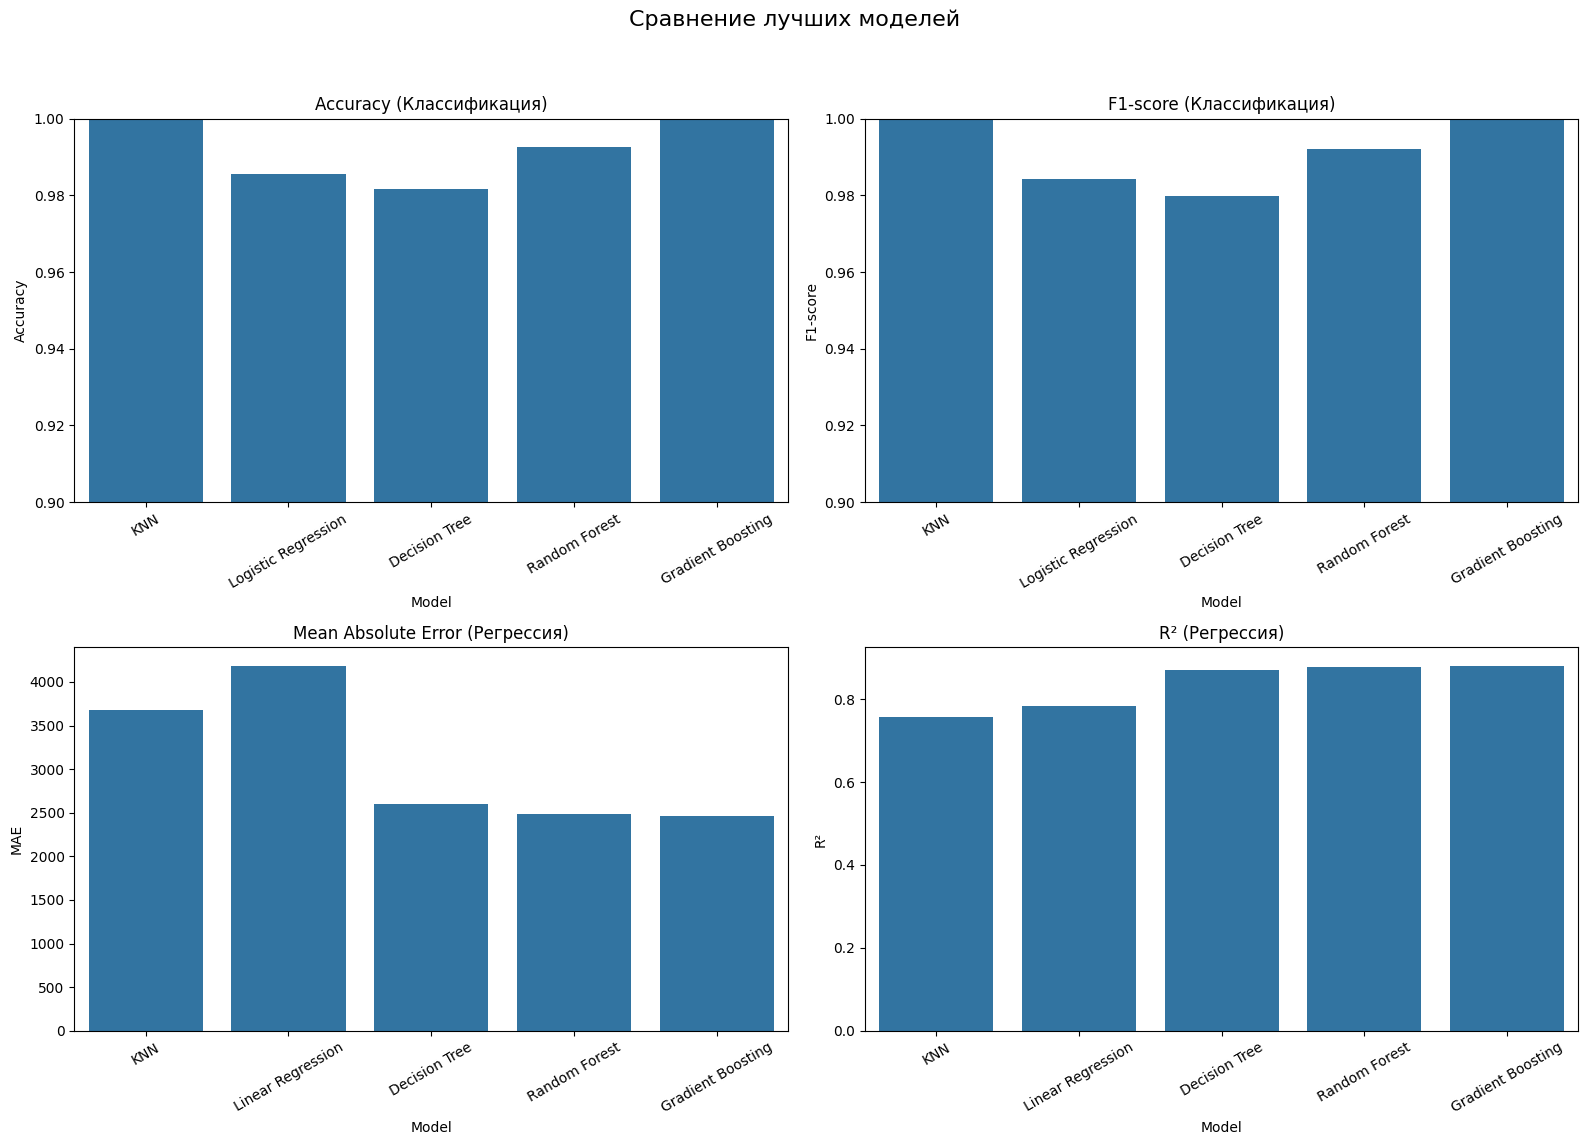

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Задача классификации
classification_results = {
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [1.0000, 0.9855, 0.9818, 0.9927, 1.0000],
    'F1-score': [1.0000, 0.9843, 0.9799, 0.9921, 1.0000]
}

# Задача регрессии
regression_results = {
    'Model': ['KNN', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'MAE': [3680.04, 4186.91, 2595.07, 2488.78, 2457.27],
    'R²': [0.7565, 0.7834, 0.8693, 0.8774, 0.8807]
}

df_clf_results = pd.DataFrame(classification_results)
df_reg_results = pd.DataFrame(regression_results)

print("Результаты для задачи классификации:")
print(df_clf_results)
print("\nРезультаты для задачи регрессии:")
print(df_reg_results)

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение лучших моделей', fontsize=16)

# Классификация - Accuracy
sns.barplot(x='Model', y='Accuracy', data=df_clf_results, ax=axes[0, 0])
axes[0, 0].set_title('Accuracy (Классификация)')
axes[0, 0].set_ylim(0.9, 1.0)

# Классификация - F1-score
sns.barplot(x='Model', y='F1-score', data=df_clf_results, ax=axes[0, 1])
axes[0, 1].set_title('F1-score (Классификация)')
axes[0, 1].set_ylim(0.9, 1.0)

# Регрессия - MAE
sns.barplot(x='Model', y='MAE', data=df_reg_results, ax=axes[1, 0])
axes[1, 0].set_title('Mean Absolute Error (Регрессия)')

# Регрессия - R²
sns.barplot(x='Model', y='R²', data=df_reg_results, ax=axes[1, 1])
axes[1, 1].set_title('R² (Регрессия)')


for ax in axes.flat:
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Глобальные выводы по всему исследованию

**Задача классификации (Banknote Authentication):**
Все рассмотренные модели после настройки показали очень высокое качество (Accuracy и F1-score > 0.97). Это говорит о том, что данные являются хорошо и, вероятно, линейно разделимыми. Лучшую производительность показали KNN и градиентный бустинг.

**Задача регрессии (Medical Cost):**
В этой задаче наблюдалась значительная разница в производительности моделей. Ключевым фактором успеха была правильная предобработка данных, в частности, кодирование категориальных признаков, без которого ни одна модель не показывала приемлемого качества. Ансамблевые методы, случайный лес и градиентный бустинг, продемонстрировали наилучшие результаты, превзойдя остальные модели по обеим метрикам.